In [79]:
import os
import shap
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import seaborn as sns
from pygam import LinearGAM, s
from numpy import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error

# SVR

## Load data

In [80]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned/', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

1760

In [81]:
# df = df[df["soil region"] != "veen"]
# len(df)

## Sort by date

In [82]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [83]:
df = df.drop(columns=['soil region'])
df = df.dropna()
len(df)

952

## Add year and month as features

In [84]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Log transform

In [85]:
df["nitrate"] = np.log1p(df["nitrate"])

## Change column type

In [86]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [87]:
df.dtypes

bro-id                                   object
nitrate                                 float64
geometry                                 object
date                        datetime64[ns, UTC]
landuse code                           category
population                              float64
groundwater depth                       float64
elevation                               float64
lon                                     float64
lat                                     float64
precipitation                           float64
temperature                             float64
n deposition                            float64
mainsoilclassification_1               category
organicmattercontent_1                  float64
density_1                               float64
acidity_1                               float64
month                                     int32
year                                      int32
dtype: object

## Remove nitrate outliers

In [88]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 211


,bro-id,nitrate,geometry,date,landuse code,population,groundwater depth,elevation,lon,lat,precipitation,temperature,n deposition,mainsoilclassification_1,organicmattercontent_1,density_1,acidity_1,month,year
8,GAR000000034413,2.006871,POINT (5.17098998 52.255863824),2008-08-12 11:00:00+00:00,22.0,0.0,0.025208,2.750871,5.170990,52.255864,14.00,175.450000,20.618304,Kalkloze zandgronden,4.0,1.355,4.8,8,2008
9,GAR000000034923,0.610852,POINT (5.273031977 52.149856205),2008-08-12 11:00:00+00:00,11.0,0.0,2.917014,7.010535,5.273032,52.149856,14.00,175.450000,29.554770,Kalkloze zandgronden,3.0,1.473,3.4,8,2008
22,GAR000000050444,2.708050,POINT (5.439743838 52.001456012),2008-09-16 10:00:00+00:00,11.0,15.0,5.036337,15.743617,5.439744,52.001456,2.25,173.216667,26.221104,Dikke eerdgronden,4.8,1.395,4.4,9,2008
23,GAR000000000644,2.302585,POINT (5.391427046 52.01540844),2008-09-16 10:00:00+00:00,12.0,15.0,3.075021,20.816914,5.391427,52.015408,2.25,173.216667,30.661323,Kalkloze zandgronden,3.0,1.473,3.4,9,2008
30,GAR000000000449,0.405465,POINT (5.470288289 52.044365667),2008-09-16 10:00:00+00:00,2.0,10.0,4.675278,12.031865,5.470288,52.044366,2.25,173.216667,26.277132,Podzolgronden,4.8,1.400,4.7,9,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,GAR000000043740,1.602816,POINT (5.309488007 52.05155101),2022-08-10 11:00:00+00:00,251.0,100.0,3.669948,7.882928,5.309488,52.051551,0.00,184.416667,22.747368,Kalkloze zandgronden,3.0,1.473,3.4,8,2022
1694,GAR000000043830,0.656483,POINT (5.273031977 52.149856205),2022-08-15 11:00:00+00:00,11.0,0.0,2.130075,7.010535,5.273032,52.149856,0.00,190.316667,21.976983,Kalkloze zandgronden,3.0,1.473,3.4,8,2022
1705,GAR000000043951,0.727065,POINT (5.17098998 52.255863824),2023-06-12 11:00:00+00:00,28.0,0.0,0.492249,2.750871,5.170990,52.255864,0.00,132.100000,16.640316,Kalkloze zandgronden,4.0,1.355,4.8,6,2023
1722,GAR000000043864,1.862218,POINT (5.309488007 52.05155101),2023-07-24 11:00:00+00:00,251.0,100.0,3.729424,7.882928,5.309488,52.051551,30.50,184.450000,23.363676,Kalkloze zandgronden,3.0,1.473,3.4,7,2023


<Axes: >

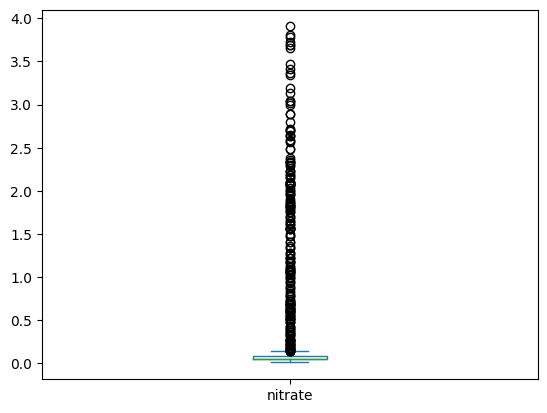

In [89]:
df[["nitrate"]].plot(kind = "box")

In [90]:
top_nitrate_outliers = list(df["nitrate"].sort_values()[-5:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

947

## Test / train split

In [91]:
train_df = df[df["year"].isin(list(range(2008, 2021)))]
test_df  = df[df["year"].isin([2021, 2022, 2023])]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

Train: 770
Test: 177


## Preprocess data

In [92]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [93]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['landuse code', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [94]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [95]:
svr = SVR()

In [96]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("svr", svr)
])

In [97]:
param_dist = {
    "svr__C": [0.1, 1, 10, 100],
    "svr__gamma": ['scale', 'auto'],
    "svr__epsilon": [0.01, 0.1, 0.2],
    "svr__kernel": ['rbf']  # rbf = radial basis function, standard for non-linear regression
}

In [98]:
# Fit transformer
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Fit GAM model
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6)).fit(X_train_processed, y_train)  # Adjust `s(i)` per feature

# Predictions
pred_train = gam.predict(X_train_processed)
pred_test = gam.predict(X_test_processed)

# Evaluate
train_r2 = r2_score(np.expm1(y_train), np.expm1(pred_train))
test_r2 = r2_score(np.expm1(y_test), np.expm1(pred_test))
train_mae = mean_absolute_error(y_train, pred_train)
test_mae = mean_absolute_error(y_test, pred_test)
train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(pred_train)))
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred_test)))

(train_r2, test_r2, train_mae, test_mae, train_rmse, test_rmse)

(-0.026743900592193892,
 0.0055981547830397105,
 0.4504026559445383,
 0.40462672827644686,
 4.055628116622191,
 2.10251121051774)

## Hyperparameter tuning

In [99]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,  # SVR is slower, reduce iterations if needed
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    verbose=1,
    random_state=9,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [100]:
print("Best CV MSE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MSE: 0.1584488009298882
Best params: {'svr__kernel': 'rbf', 'svr__gamma': 'scale', 'svr__epsilon': 0.01, 'svr__C': 1}


## Learning curve

In [101]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [102]:
n = len(X_train)

train_errors = []
val_errors = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=6)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = best_model
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))

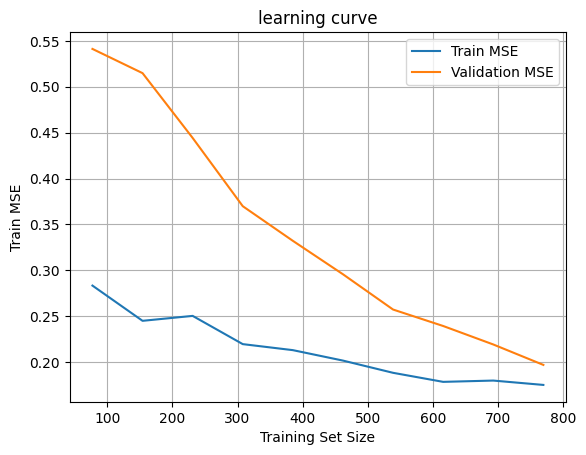

In [103]:
plt.plot(train_sizes * len(X_train), train_errors, label="Train MSE")
plt.plot(train_sizes * len(X_train), val_errors, label="Validation MSE")
plt.xlabel("Training Set Size")
plt.ylabel("Train MSE")
plt.title("learning curve")
plt.legend()
plt.grid(True)
plt.show()

## Final Train score

In [104]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(np.expm1(y_train), np.expm1(pred_train)))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_train), np.expm1(pred_train))))

Train R2: 0.5404501500900585
Train MAE: 0.12571572024670996
Test RMSE: 2.7132722540569634


## Final Test score

In [105]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(np.expm1(y_test), np.expm1(pred_nitrate)))
print("Test MAE:", mean_absolute_error(y_test, pred_nitrate))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred_nitrate))))

Test R2: 0.755624001505908
Test MAE: 0.13555845267143476
Test RMSE: 1.0422853510981254


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

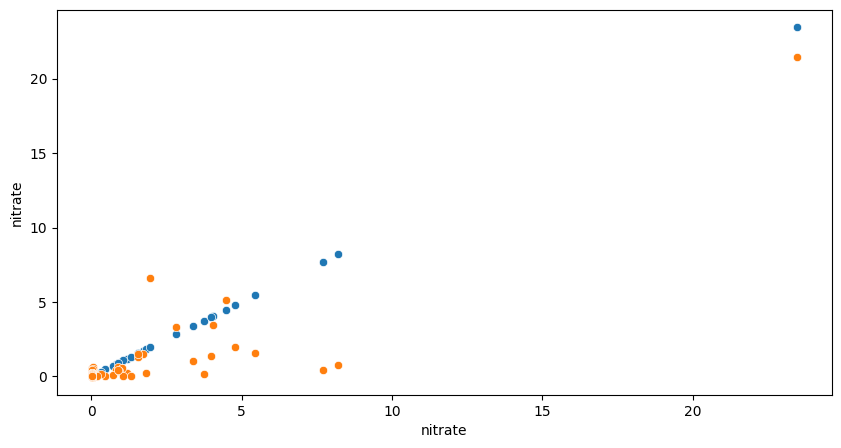

In [106]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = np.expm1(y_test), y = np.expm1(y_test), ax = ax)
sns.scatterplot(x = np.expm1(y_test), y = np.expm1(pred_nitrate), ax = ax)

In [107]:
# fix, ax = plt.subplots(figsize= (10,5))

# sns.scatterplot(x = y_test, y = y_test, ax = ax)
# sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

Text(0, 0.5, 'Residuals')

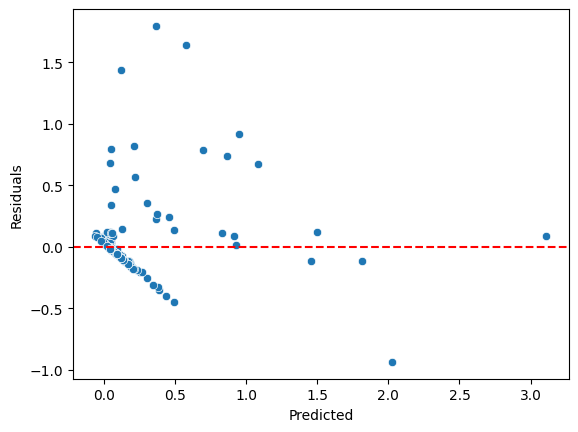

In [108]:
preds = best_model.predict(X_test)

residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Interpretability

In [109]:
xgb_model = best_model.named_steps["svr"]
feature_names = best_model.named_steps["prep"].get_feature_names_out()

### Default interpretability: Gain

In [110]:
feature_names = best_model.named_steps["prep"].get_feature_names_out()

importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

AttributeError: 'SVR' object has no attribute 'feature_importances_'

In [150]:
booster = xgb_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

importance_types = ["gain", "cover", "weight"]
# importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

In [151]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

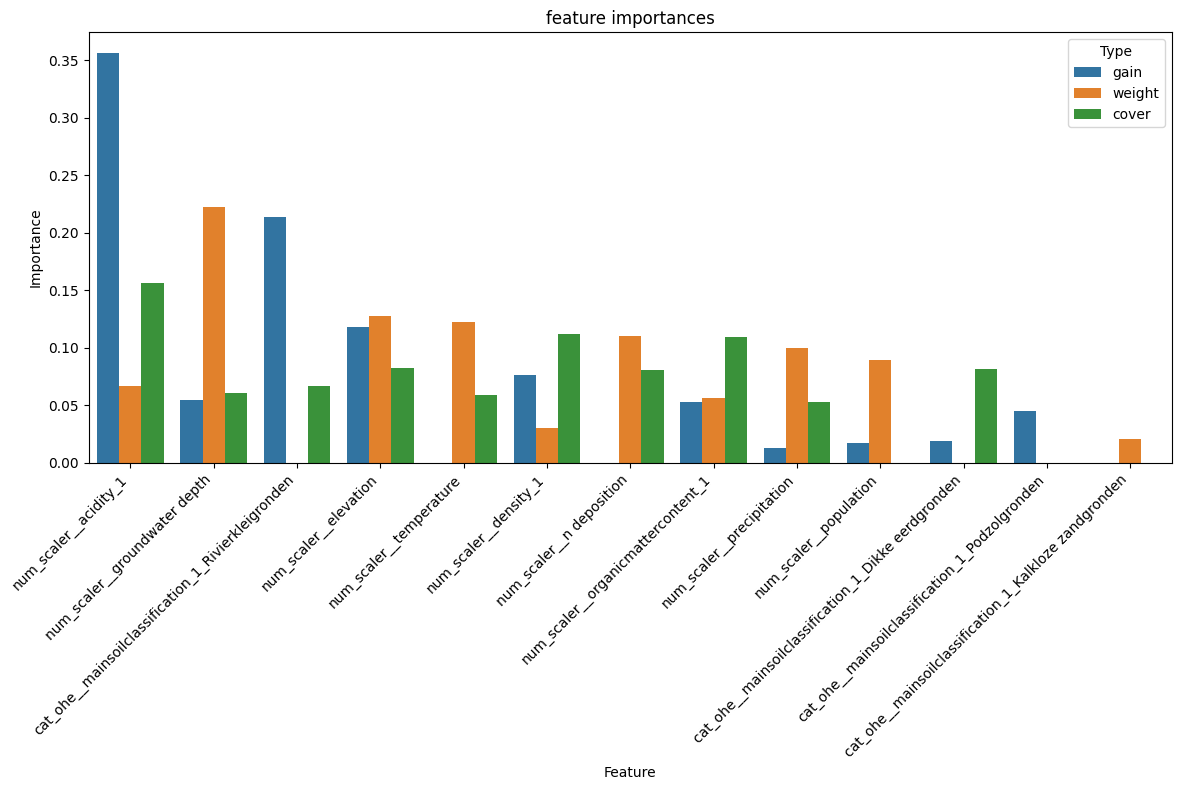

In [152]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [153]:
feature_names = best_model.named_steps["prep"].get_feature_names_out()
X_test_transformed = best_model.named_steps["prep"].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

## Permutation

In [154]:
result = permutation_importance(
    estimator=best_model.named_steps["xgb"],  # just the model
    X=X_test_transformed,
    y=y_test,
    n_repeats=30,
    random_state=42,
    scoring="r2",
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean,
    "Type": "permutation"
})

perm_df["Importance"] /= perm_df["Importance"].sum()

combined_df = pd.concat([importances_df, perm_df], axis=0)

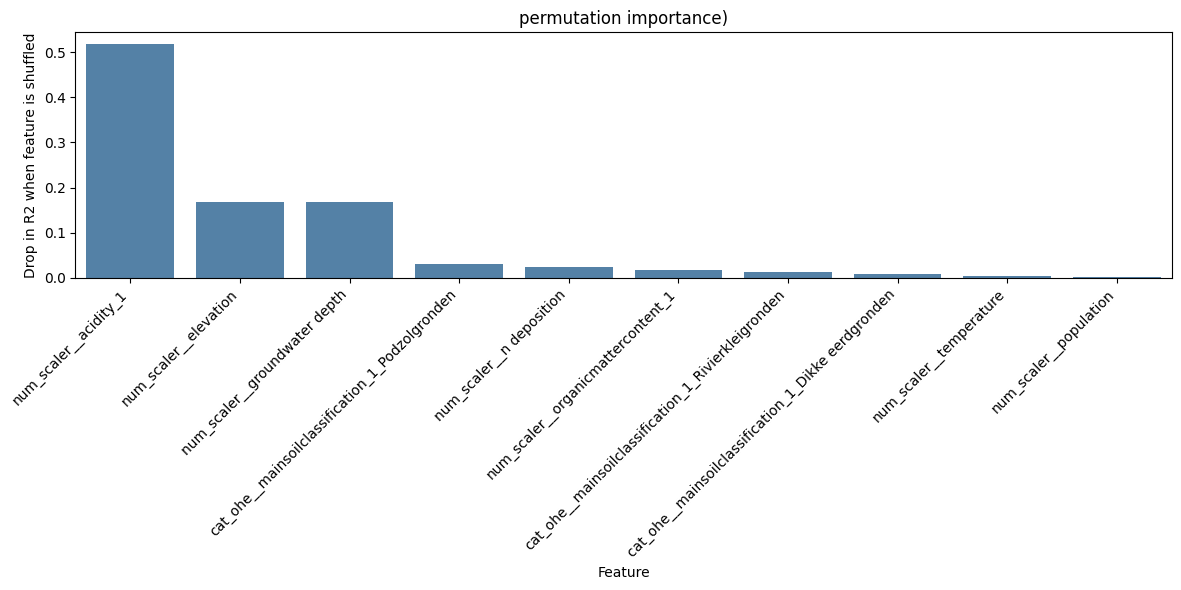

In [155]:
perm_df_raw = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean,
    "Std": result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=perm_df_raw.head(10),
    x="Feature",
    y="Importance",
    color="steelblue"
)
plt.xticks(rotation=45, ha="right")
plt.title("permutation importance)")
plt.ylabel("Drop in R2 when feature is shuffled")
plt.tight_layout()
plt.show()

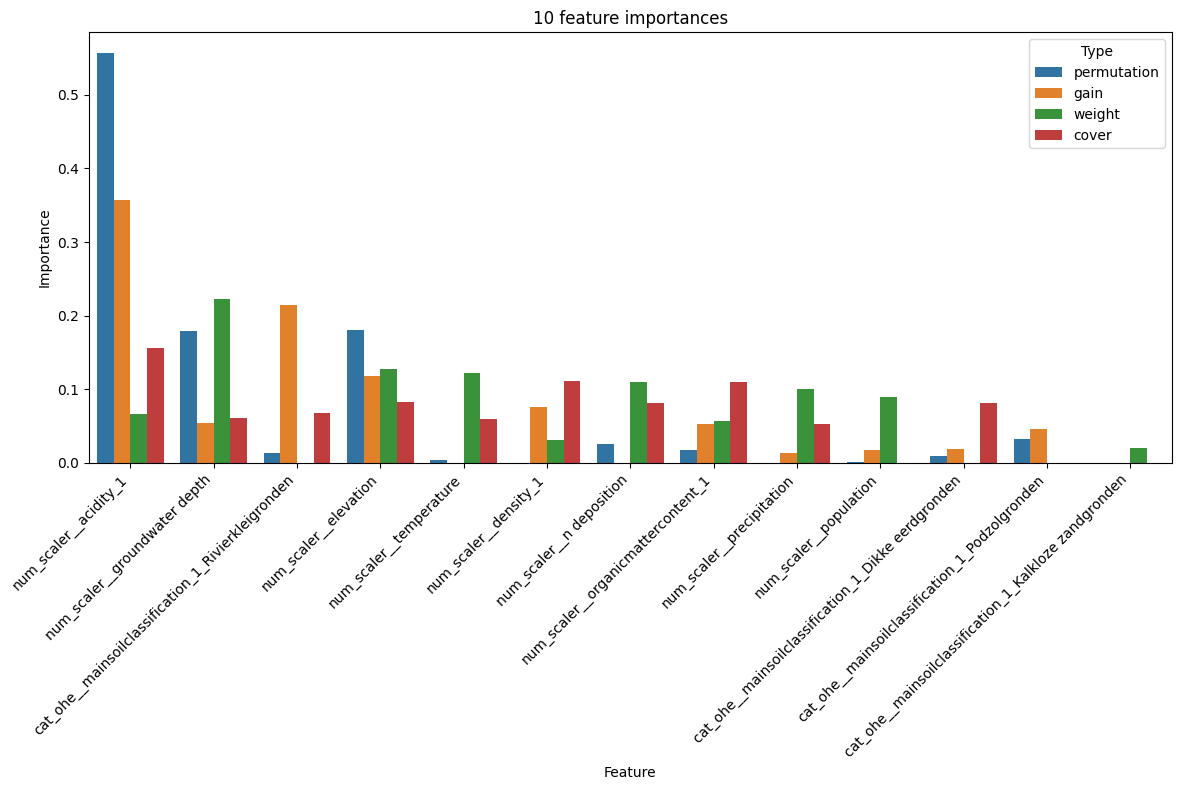

In [156]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

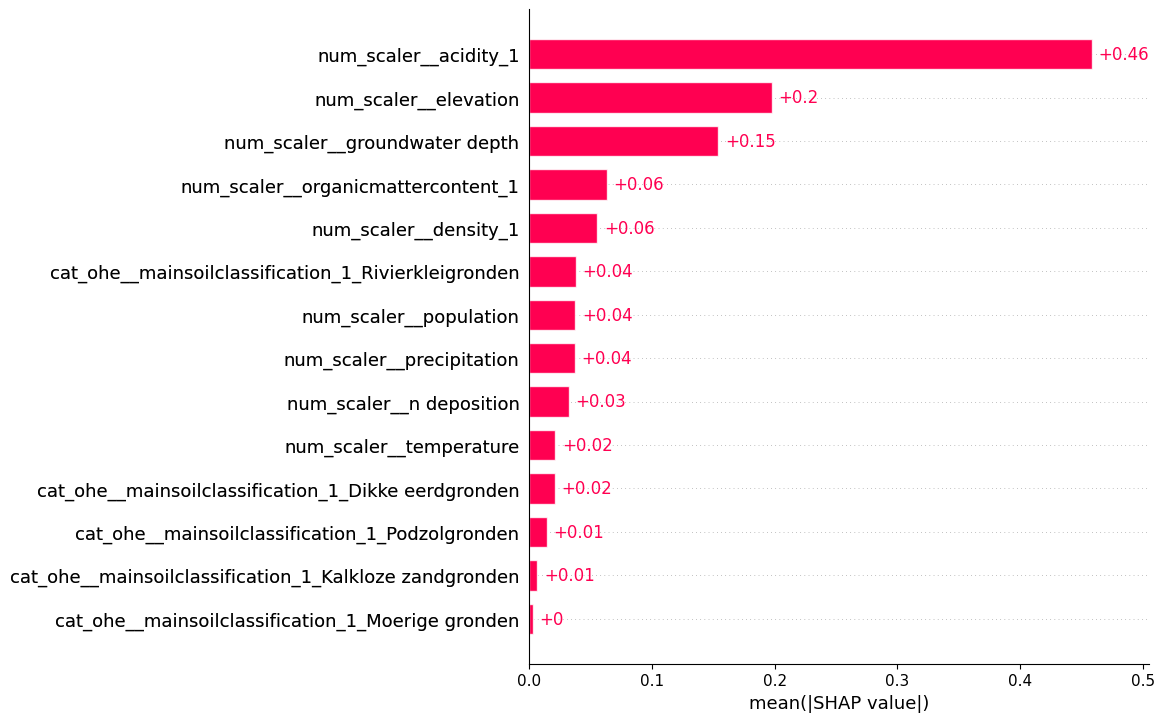

In [157]:
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_transformed_df)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)

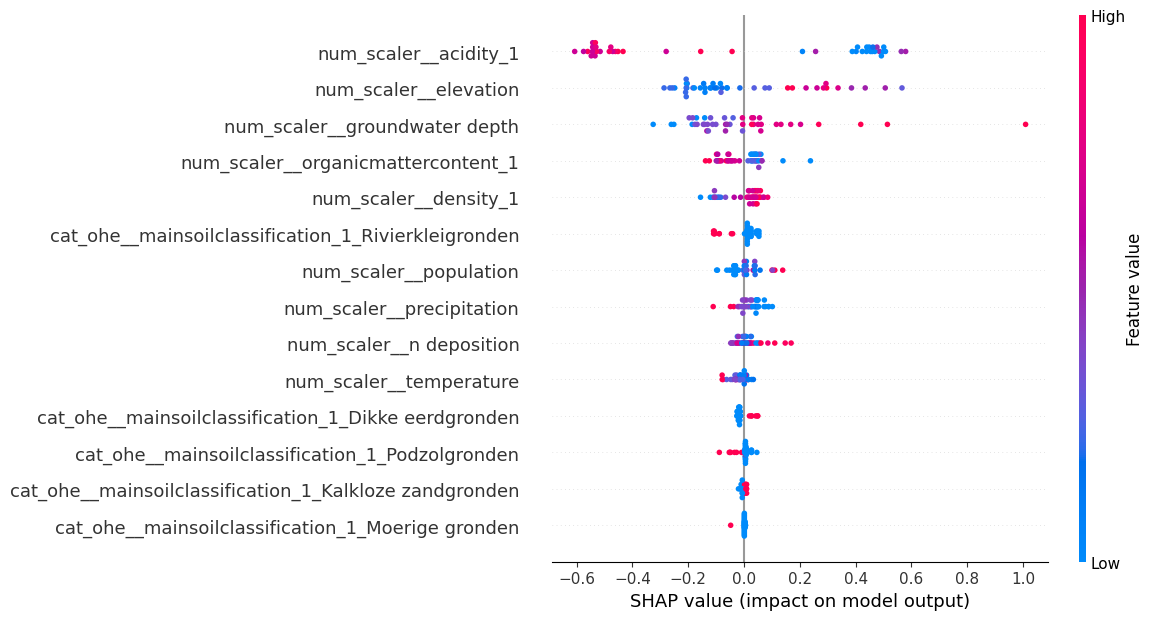

In [158]:
shap.plots.beeswarm(shap_explanation, max_display=15)